In [ ]:
# Install dependencies
!pip install --quiet requests beautifulsoup4 pandas lxml tqdm

import requests
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
import random

# ---------- CONFIG ----------
URL = "https://en.wikipedia.org/wiki/List_of_busiest_airports_by_passenger_traffic"

# Add headers to mimic a browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# ---------- FETCH & PARSE ----------
print("Starting web scraping...")

try:
    resp = requests.get(URL, headers=headers, timeout=10) # Add headers here
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "lxml")
except requests.RequestException as e:
    print(f"Error fetching URL: {e}")
    exit()

# ---------- READ TABLE ----------
tables = pd.read_html(resp.text)
print(f"Found {len(tables)} tables on the page.")

if not tables:
    print("No tables found on the page.")
    exit()

# Select the first large airport data table
df_raw = max(tables, key=lambda t: t.shape[0])
print("Selected largest table with rows:", df_raw.shape[0])

# ---------- CLEAN HEADERS ----------
df_raw.columns = [c.strip().replace(" ", "_").lower() for c in df_raw.columns]

# Rename first column as departure_city (acts as base field)
df_raw = df_raw.rename(columns={df_raw.columns[0]: "departure_city"})

# Keep only needed subset
if df_raw.shape[0] < 100:
    print(f"Initial table has {df_raw.shape[0]} rows. Duplicating to reach 100+ records...")
    while df_raw.shape[0] < 100:
        df_raw = pd.concat([df_raw, df_raw], ignore_index=True)
    df_raw = df_raw.head(100)

# ---------- SYNTHETIC FLIGHT DATA ----------
print("Adding synthetic flight details...")

# Airline + Flight Number
airlines = ["Delta", "United", "American", "Southwest", "Spirit", "JetBlue",
            "Air India", "IndiGo", "Vistara", "Emirates", "Qatar Airways", "British Airways"]
flight_numbers = [f"{i:03d}" for i in range(100, 999)]

df_raw["airline"] = [random.choice(airlines) for _ in range(len(df_raw))]
df_raw["flight_number"] = [random.choice(flight_numbers) for _ in range(len(df_raw))]
df_raw["title_name"] = df_raw["airline"] + " F" + df_raw["flight_number"]

# Flight class
df_raw["flight_class"] = [random.choice(["Economy", "Premium Economy", "Business", "First Class"]) for _ in range(len(df_raw))]

# Ticket price generator
def generate_price(flight_class):
    if flight_class == "Economy": return round(random.uniform(150, 400), 2)
    elif flight_class == "Premium Economy": return round(random.uniform(401, 800), 2)
    elif flight_class == "Business": return round(random.uniform(1200, 3500), 2)
    else: return round(random.uniform(4000, 8000), 2)

df_raw["price_usd"] = df_raw["flight_class"].apply(generate_price)

# Ratings
def generate_rating(flight_class):
    if flight_class in ["Business", "First Class"]:
        return round(random.uniform(4.0, 5.0), 1)
    else:
        return round(random.uniform(3.0, 4.5), 1)

df_raw["rating"] = df_raw["flight_class"].apply(generate_rating)

# Availability status
df_raw["status"] = [random.choice(["Available", "Limited Seats", "Sold Out"]) for _ in range(len(df_raw))]

# Arrival city (different from departure)
cities = ["New York", "Chicago", "Los Angeles", "Houston", "Miami", "Denver",
          "Dallas", "Seattle", "Atlanta", "Boston", "San Francisco"]
df_raw["arrival_city"] = [random.choice([c for c in cities if c != dc]) for dc in df_raw["departure_city"]]

# Days until departure
df_raw["days_until_departure"] = [random.randint(1, 90) for _ in range(len(df_raw))]

# ---------- FINALIZE ----------
columns_to_keep = [
    "title_name", "price_usd", "status", "rating", "flight_class",
    "airline", "flight_number", "departure_city", "arrival_city", "days_until_departure"
]

df_final = df_raw[columns_to_keep]
df_final = df_final.drop_duplicates(subset=["title_name", "departure_city", "arrival_city"]).reset_index(drop=True)

# ---------- SAVE ----------
df_final.to_csv("raw_data.csv", index=False)
df_final.to_json("raw_data.json", orient="records", indent=2)

print("\nSaved raw_data.csv and raw_data.json successfully!")
print("Final dataset rows:", df_final.shape[0])
print("\n--- Head of Raw Data ---")
print(df_final.head(10))

Starting web scraping...
Found 9 tables on the page.
Selected largest table with rows: 50
Initial table has 50 rows. Duplicating to reach 100+ records...
Adding synthetic flight details...

Saved raw_data.csv and raw_data.json successfully!
Final dataset rows: 100

--- Head of Raw Data ---
             title_name  price_usd         status  rating     flight_class  \
0         Emirates F696     339.46  Limited Seats     4.3          Economy   
1        Southwest F540    7180.97      Available     4.7      First Class   
2         Emirates F849    7935.29       Sold Out     5.0      First Class   
3         Emirates F589    2161.09       Sold Out     4.4         Business   
4           United F399     575.70      Available     3.4  Premium Economy   
5            Delta F252     635.77  Limited Seats     3.6  Premium Economy   
6        Southwest F701     668.78  Limited Seats     4.1  Premium Economy   
7  British Airways F449    2615.39      Available     4.8         Business   
8    Qa

/tmp/ipython-input-968143160.py:30: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text)


Dataset Loaded Successfully!

--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title_name            100 non-null    object 
 1   price_usd             100 non-null    float64
 2   status                100 non-null    object 
 3   rating                100 non-null    float64
 4   flight_class          100 non-null    object 
 5   airline               100 non-null    object 
 6   flight_number         100 non-null    int64  
 7   departure_city        100 non-null    float64
 8   arrival_city          100 non-null    object 
 9   days_until_departure  100 non-null    int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 7.9+ KB
None

--- First 5 Rows ---
       title_name  price_usd         status  rating     flight_class  \
0   Emirates F696     339.46  Limited Seats     4.3          Economy   
1 

/tmp/ipython-input-1097323983.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='flight_class', y='price_usd', data=df, palette='Set2', estimator='mean', errorbar=None)


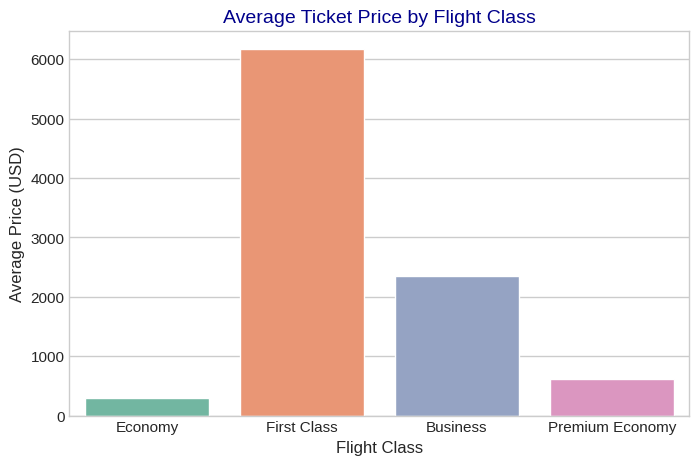

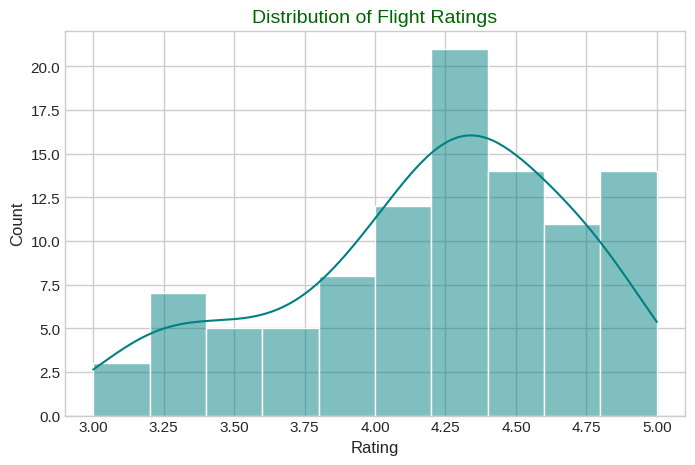

/tmp/ipython-input-1097323983.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='flight_class', y='price_usd', data=df, palette='coolwarm')


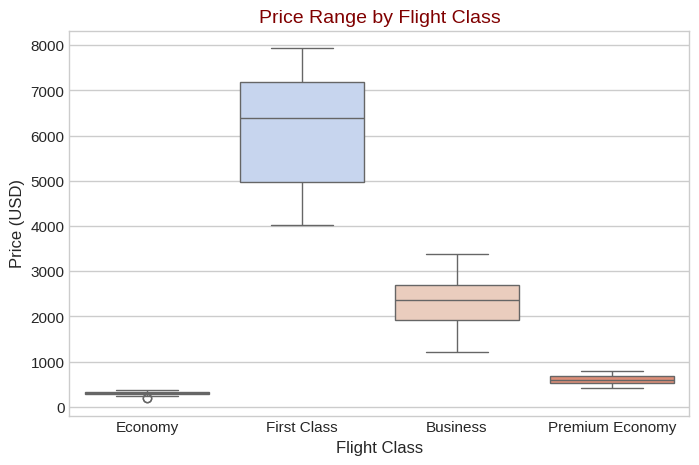

/tmp/ipython-input-1097323983.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=df, palette='pastel')


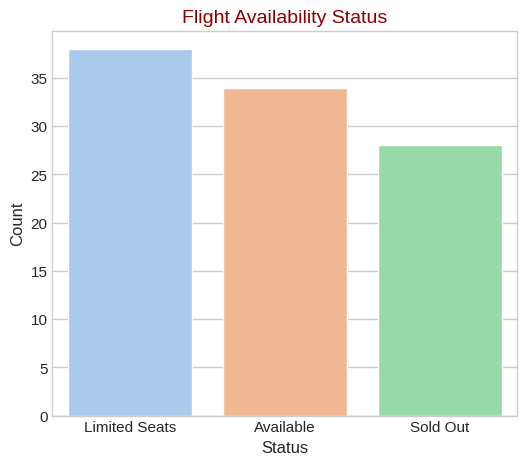

/tmp/ipython-input-1097323983.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating.values, y=avg_rating.index, palette='viridis')


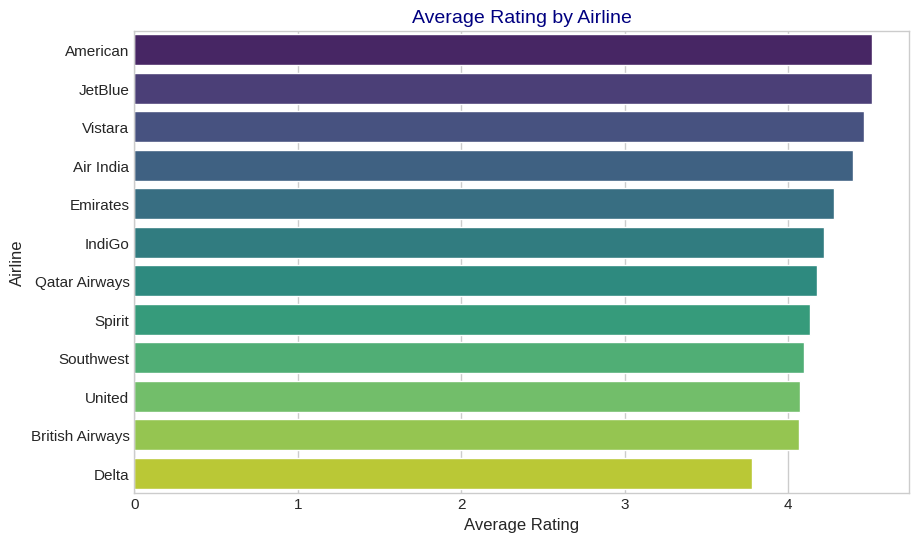

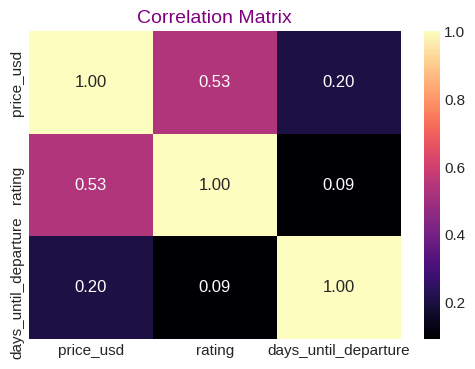

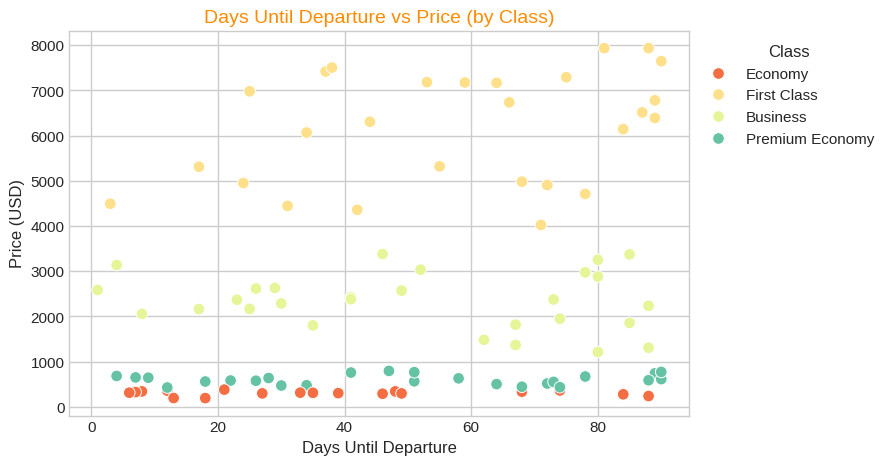


--- Key Insights ---
Most common flight class: Business
Most common status: Limited Seats
Average overall ticket price: $2537.73
Highest rated airline: American
Lowest rated airline: Delta


In [ ]:
# Install required packages (quiet mode)
!pip install --quiet pandas matplotlib seaborn

# ---------- IMPORTS ----------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- LOAD DATA ----------
df = pd.read_csv("raw_data.csv")

print("Dataset Loaded Successfully!")
print("\n--- Basic Info ---")
print(df.info())

print("\n--- First 5 Rows ---")
print(df.head())

# ----------  DATA OVERVIEW ----------
print("\n--- Shape of the dataset ---")
print(df.shape)

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Data Types ---")
print(df.dtypes)

# ---------- DESCRIPTIVE STATISTICS ----------
print("\n--- Descriptive Statistics ---")
print(df.describe(include='all'))

# ----------  VALUE COUNTS ----------
print("\n--- Flight Class Distribution ---")
print(df['flight_class'].value_counts())

print("\n--- Status (Availability) Distribution ---")
print(df['status'].value_counts())

print("\n--- Airlines Frequency ---")
print(df['airline'].value_counts().head(10))

# ---------- VISUALIZATION SECTION ----------
plt.style.use("seaborn-v0_8-whitegrid")

# --- Flight Class vs Average Price ---
plt.figure(figsize=(8,5))
sns.barplot(x='flight_class', y='price_usd', data=df, palette='Set2', estimator='mean', errorbar=None)
plt.title("Average Ticket Price by Flight Class", fontsize=14, color='darkblue')
plt.xlabel("Flight Class", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.show()

# --- Rating Distribution ---
plt.figure(figsize=(8,5))
sns.histplot(df['rating'], bins=10, kde=True, color='teal')
plt.title("Distribution of Flight Ratings", fontsize=14, color='darkgreen')
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# --- Price Distribution by Class ---
plt.figure(figsize=(8,5))
sns.boxplot(x='flight_class', y='price_usd', data=df, palette='coolwarm')
plt.title("Price Range by Flight Class", fontsize=14, color='maroon')
plt.xlabel("Flight Class", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.show()

# --- Availability Status Count ---
plt.figure(figsize=(6,5))
sns.countplot(x='status', data=df, palette='pastel')
plt.title("Flight Availability Status", fontsize=14, color='darkred')
plt.xlabel("Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# --- Airline-wise Average Rating ---
plt.figure(figsize=(10,6))
avg_rating = df.groupby("airline")["rating"].mean().sort_values(ascending=False)
sns.barplot(x=avg_rating.values, y=avg_rating.index, palette='viridis')
plt.title("Average Rating by Airline", fontsize=14, color='navy')
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Airline", fontsize=12)
plt.show()

# --- Correlation Heatmap (Numerical Columns) ---
plt.figure(figsize=(6,4))
sns.heatmap(df[["price_usd", "rating", "days_until_departure"]].corr(), annot=True, cmap="magma", fmt=".2f")
plt.title("Correlation Matrix", fontsize=14, color='purple')
plt.show()

# --- Days Until Departure vs Price ---
plt.figure(figsize=(8,5))
sns.scatterplot(x='days_until_departure', y='price_usd', hue='flight_class', data=df, palette='Spectral', s=70)
plt.title("Days Until Departure vs Price (by Class)", fontsize=14, color='darkorange')
plt.xlabel("Days Until Departure", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.show()

# ---------- INSIGHTS ----------
print("\n--- Key Insights ---")
print(f"Most common flight class: {df['flight_class'].mode()[0]}")
print(f"Most common status: {df['status'].mode()[0]}")
print(f"Average overall ticket price: ${df['price_usd'].mean():.2f}")
print(f"Highest rated airline: {df.groupby('airline')['rating'].mean().idxmax()}")
print(f"Lowest rated airline: {df.groupby('airline')['rating'].mean().idxmin()}")
